# fixed configuration

In [ ]:
import pandas as pd
import wandb
import numpy as np
import re
api = wandb.Api()
account_name = "ai4quake"
project_name_list = [p.name for p in api.projects(
) if "TSL" in p.name and "Old" not in p.name]
job_maping={'96_48_96' :"096",
            '96_96_96' :"096",
            '96_48_192':"192",
            '96_96_192':"192",
            '96_48_336':"336",
            '96_96_336':"336",
            '96_48_720':"720",
            '96_96_720':"720"}
model_name_mapping = {
    "TimesNet": "TimesNet",
    "Pyraformer": "Pyraformer",
    "MICN": "MICN",
    "Crossformer": "Crossformer",
    "Autoformer": "Autoformer",
    "Transformer": "Transformer",
    "PatchTST": "PatchTST",
    "Nonstationary_Transformer": "Stationary",
    "Reformer": "Reformer",
    "LightTS": "LightTS",
    "Informer": "Informer",
    "FEDformer": "FEDformer",
    "DLinear": "DLinear",
    "ETSformer": "ETSformer",
}

In [2]:
#rawdata = []
pool = {}
fail_trail = []
for name in project_name_list:
    if "ili" in name:
        continue
    if name not in pool:
        pool[name] = {}
    runs = api.runs(path=f"{account_name}/{name}")
    for run in runs:
        #if run.name[:5] not in ['04_24','04_25','04_26','04_27','04_28','04_29','04_30']:continue
        model = run.group
        graph = run.config['compute_graph_set']
        if run.config['learning_rate'] != 2e-5:continue
        #graph = run.config['pretrain_weight']
        if model not in pool[name]:
            pool[name][model] = {}
        if graph not in pool[name][model]:
            pool[name][model][graph] = []
        pool[name][model][graph].append(run.name)

raw_data = []
for dataset, model_pool in pool.items():
    for model, graph_pool in model_pool.items():
        for graph, _list in graph_pool.items():
            raw_data.append([dataset, model, graph, len(_list)])

# Create raw data for the table

# Create a Pandas DataFrame from raw data
df = pd.DataFrame(raw_data, columns=['dataset', 'model', 'graph', 'num'])

df_pivot = df.pivot_table(index=['model', 'graph'], columns=[
                          'dataset'], values='num')


styled_df = df_pivot.style.format("{:.0f}").set_table_styles([
    {'selector': 'th', 'props': [
        ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th.level0', 'props': [('border-bottom', '3px solid black')]},
    {'selector': 'th.level1', 'props': [('border-bottom', '2px solid black')]},
    {'selector': 'th.level2', 'props': [('border-bottom', '1px solid black')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
])

# Display the styled DataFrame in Jupyter Notebook
styled_df

In [8]:
import os

In [19]:
from tbparse import SummaryReader

In [33]:
def get_error_pool_from_event(event_path,error_select):
    reader = SummaryReader(event_path)
    df = reader.scalars
    if 'tag' not in reader.hparams:
        print(f"no hparams at {log_dir}")
        #print(reader.hparams)
    all_pool={}
    #print("start parsing tensorboard..............")
    for key in set(df['tag'].values):
        if key not in error_select:continue
        now   = df[df['tag'] == key]
        steps = now['step'].values
        values= now['value'].values
        for step, val in zip(steps,values):
            if step not in all_pool:all_pool[step]={}
            all_pool[step][key]=val
    return all_pool

In [38]:
!ls checkpoints/TSL-traffic/Crossformer/TTM.96_48_96/bs_16fwd2_D/08_05_18_36_26-seed_2021

config.json						  log.info
events.out.tfevents.1691231799.dsw-28053-ff8b87c56-r7rzz  runtime.log


In [77]:
run.config['seed']

2021

In [78]:
from tqdm.auto import tqdm

#rawdata = []
pool = {}
error_name = "test_error_336"

for name in tqdm(project_name_list):
    if "ili" in name:continue
    if "ECL" in name:continue
    #if "traffic" in name:continue
    runs = api.runs(path=f"{account_name}/{name}")
    for run in tqdm(runs):
        #if run.config['learning_rate'] != 2e-5:continue
        if run.config['learning_rate'] != 1e-5:continue
        if run.config['seed'] != 2023:continue
        model = model_name_mapping[run.group]
        job_type = job_maping[run.job_type.split('.')[-1]]
        task = name.replace('TSL-',"")
        graph= run.config['compute_graph_set'].split('_')[-1]
        path = run.config['SAVE_PATH']
        if not os.path.exists(path):
            print(f"NOT EXIST! ==>  {path}  <== continue")
            continue
        if "results" not in os.listdir(path):
            print(f"BAD TRIALS! ==>  {path}  <== continue")
            continue
        event_file_list =  [f for f in os.listdir(path) if 'event' in f]
        if len(event_file_list)>1:print(f"check {path}")
        event_path = os.path.join(path, event_file_list[0])
        
        error_pool = get_error_pool_from_event(event_path,["test_error_96","test_error_192","test_error_336","test_error_720"])
        last_error = error_pool[max(error_pool.keys())]
        for error_name, error in last_error.items():
            job_type = error_name.split("_")[-1]
            key = f"{task}={job_type}={model}"
            if key not in pool:pool[key] = []
            pool[key].append([graph,error])  

        #rawdata.append([task,job_type,model,mse])

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

BAD TRIALS! ==>  ./checkpoints/TSL-traffic/Pyraformer/TTM.96_48_96/bs_32fwd2_D.lr1e-05.seed2023/08_06_23_35_27-seed_2023  <== continue
BAD TRIALS! ==>  ./checkpoints/TSL-traffic/TimesNet/TTM.96_48_96/bs_32fwd2_D.lr1e-05.seed2023/08_06_23_35_24-seed_2023  <== continue
BAD TRIALS! ==>  ./checkpoints/TSL-traffic/Crossformer/TTM.96_48_96/bs_16fwd2_D.lr1e-05.seed2023/08_06_23_33_42-seed_2023  <== continue
BAD TRIALS! ==>  ./checkpoints/TSL-traffic/FEDformer/TTM.96_48_96/bs_32fwd2_D.lr1e-05.seed2023/08_06_23_28_06-seed_2023  <== continue
BAD TRIALS! ==>  ./checkpoints/TSL-traffic/Informer/TTM.96_48_96/bs_32fwd2_D.lr1e-05.seed2023/08_06_23_26_51-seed_2023  <== continue
BAD TRIALS! ==>  ./checkpoints/TSL-traffic/Nonstationary_Transformer/TTM.96_48_96/bs_32fwd2_D_Rog5.lr1e-05.seed2023/08_06_22_44_42-seed_2023  <== continue
BAD TRIALS! ==>  ./checkpoints/TSL-traffic/Pyraformer/TTM.96_48_96/bs_32fwd2_D_Rog5.lr1e-05.seed2023/08_06_22_43_18-seed_2023  <== continue
BAD TRIALS! ==>  ./checkpoints/TSL

  0%|          | 0/66 [00:00<?, ?it/s]

In [51]:
import json
with open('pool2_TS_table.json','r') as f:
    pool2 = json.load(f)

In [79]:
rawdata = []

for key, value in pool.items():
    task,job_type,model = key.split("=")
    if "ETSformer" in model: continue
    if "FEDformer" in model: continue    
    #if "Exchange" in task: continue
    value = sorted(value,key=lambda x:x[1])
    repeat={}
    for name, val in value:
        if name not in repeat:repeat[name]=[]
        repeat[name].append(val)
    if len(job_type)<3:job_type="0"+job_type
    for name, val in repeat.items():
        top10 = np.sort(val)[:10]
        rawdata.append([task,job_type,model,name[0],min(val),max(val),np.mean(val),np.std(val),np.mean(top10),np.std(top10)])

for key, value in pool2.items():
    task,job_type,model = key.split("=")
    if "ETSformer" in model: continue
    if "FEDformer" in model: continue    
    #if "Exchange" in task: continue
    if len(job_type)<3:job_type="0"+job_type
    value = sorted(value,key=lambda x:x[1])
    repeat={}
    for name, val in value:
        if name not in repeat:repeat[name]=[]
        repeat[name].append(val)
    for name, val in repeat.items():
        top10 = np.sort(val)[:10]
        rawdata.append([task,job_type,model,name[0],min(val),max(val),np.mean(val),np.std(val),np.mean(top10),np.std(top10)])

In [80]:
pool_table = {}
for task,length,model, rank, min_error, max_error, mean_error,std_error,top10,std10 in rawdata:
    if task not in pool_table:pool_table[task]={}
    if length not in pool_table[task]:pool_table[task][length]={}
    if model not in pool_table[task][length]:pool_table[task][length ][model]={}
    if rank not in pool_table[task][length ][model]:
        pool_table[task][length ][model][rank]=[min_error, max_error, mean_error,std_error,top10,std10]
    else:
        print(f'repeat at {task}={lenght}={model}={rank}')


import json
# with open('figures/full_TS_table.json','w') as f:
#     json.dump(pool_table,f)
# with open('figures/full_TS_table.json','r') as f:
#     pool_table = json.load(f)

In [81]:
## mean
import pandas as pd
global count_red 
global count_blue
global count_right
count_red  = 0
count_blue = 0
count_right= 0 



df = pd.DataFrame(rawdata, columns=['dataset', 'pred', 'model', 'metric', 'min_error','max_error','mean_error','std_error','top10_mean','std10'])

df = df[df['dataset']!='traffic']
df = df.loc[df['model'].isin(['Crossformer', 'DLinear','LightTS','MICN','PatchTST','TimesNet'])]
df_pivot = df.pivot_table(index=['dataset', 'pred'], columns=['model', 'metric'], values='top10_mean')

def apply_border_style(val):
    out = []
    for v in val.index:
        if   v[1] == 'A':out.append('border-left: 2px solid black')
        elif v[1] == 'A':out.append('border-right: 2px solid black')
        else:out.append('')
    return out

def apply_compare(val):
    global count_red 
    global count_blue
    global count_right
    length = len(val)
    assert length%3 == 0
    out = []
    for A,D,R in np.split(val,length//3):
        out.append('')
        if D < A:
            out.append('color: red')
            count_red+=1
        else:
            out.append('color: blue')
            count_blue+=1
        if R < A:
            out.append('color: red')
            count_red+=1
        else:
            out.append('color: blue')
            count_blue+=1
        if R <= D:
            count_right+=1
    return out

def apply_under_line_best_inblock(val):
    
    length = len(val)
    assert length%3 == 0
    out = []
    for A,D,R in np.split(val,length//3):
        min_index = np.argmin([A,D,R])
        temp = ["","",""]
        temp[min_index] = 'border-bottom: 3px solid black'
        out.extend(temp)
    return out

def highlight_min(s):
    is_min = s == np.nanmin(s)
    return ['background-color: lightblue' if v else '' for v in is_min]
styled_df = df_pivot.style.format("{:.3f}").apply(highlight_min,axis=1).apply(apply_under_line_best_inblock,axis=1).apply(apply_compare,axis=1).apply(apply_border_style,axis=1).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th.level0', 'props': [('border-bottom', '3px solid black')]},
    {'selector': 'th.level1', 'props': [('border-bottom', '2px solid black')]},
    {'selector': 'th.col_heading', 'props': [('border-right', '2px solid black')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '4px 2px')]},
    
    {'selector': 'td.col_heading.level0', 'props': [('border-left', '2px solid black')]},
    {'selector': 'td.row_heading.level1', 'props': [('border-left', '2px solid black')]},
])

styled_df


In [63]:
with open('styled_table_all_std.html', 'w') as f:
    f.write(styled_df.render())

/tmp/ipykernel_191106/321154006.py:2: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  f.write(styled_df.render())


# Varing in ETTm2

In [1]:
import pandas as pd
import wandb
import numpy as np
import re
api = wandb.Api()
account_name = "ai4quake"
project_name_list = [p.name for p in api.projects(
) if "TSL" in p.name and "Old" not in p.name]
job_maping={'96_48_96' :"096",
            '96_96_96' :"096",
            '96_48_192':"192",
            '96_96_192':"192",
            '96_48_336':"336",
            '96_96_336':"336",
            '96_48_720':"720",
            '96_96_720':"720"}
model_name_mapping = {
    "TimesNet": "TimesNet",
    "Pyraformer": "Pyraformer",
    "MICN": "MICN",
    "Crossformer": "Crossformer",
    "Autoformer": "Autoformer",
    "Transformer": "Transformer",
    "PatchTST": "PatchTST",
    "Nonstationary_Transformer": "Stationary",
    "Reformer": "Reformer",
    "LightTS": "LightTS",
    "Informer": "Informer",
    "FEDformer": "FEDformer",
    "DLinear": "DLinear",
    "ETSformer": "ETSformer",
}

In [2]:
#keys = [k for k in run.summary.keys() if 'test_error' in k]
keys = ['test_error_288',
 'test_error_720',
 'test_error_672',
 'test_error_864',
 'test_error_96',
 'test_error_576',
 'test_error_768',
 'test_error_192',
 'test_error_384',
 'test_error_480',
 'test_error_336']

In [69]:
run.state

'running'

In [3]:
#rawdata = []
pool = {}
fail_trail = []
error_pool = {}
for name in project_name_list:
    if "ili" in name:continue
    if "ETTm2" not in name:continue
    
    if name not in pool:pool[name] = {}
    runs = api.runs(path=f"{account_name}/{name}")
    for run in runs:
        if run.state != 'finished':continue
        #if run.name[:5] not in ['04_24','04_25','04_26','04_27','04_28','04_29','04_30']:continue
        model = run.group
        if model not in ["TimesNet","MICN","PatchTST"]:continue
        graph = run.config['compute_graph_set']
        if model not in pool[name]:pool[name][model] = {}
        if graph not in pool[name][model]:pool[name][model][graph] = {}
        for k in keys:
            
            if k not in pool[name][model][graph]:pool[name][model][graph][k]=[]
            pool[name][model][graph][k].append(run.summary[k])
        #pool[name][model][graph].append(run.name)

In [4]:
rawdata = []
for model, model_pool in pool['TSL-ETTm2'].items():
    for graph, graph_pool in model_pool.items():
        for error_type, error_list in graph_pool.items():
            rawdata.append([model,graph,int(error_type.replace('test_error_','')),np.mean(error_list),np.std(error_list)])

In [5]:
from mltool.visualization import *

In [36]:
color_map={
    'fwd2_D':'black',
    'fwd2_D_Rog5':'red'
}
label_map={
    'fwd2_D':'MSE',
    'fwd2_D_Rog5':'MLSE'
}
line_map={
    'fwd2_D':'dashed',
    'fwd2_D_Rog5':'solid'
}

In [12]:
import scienceplots

plt.style.use('science')

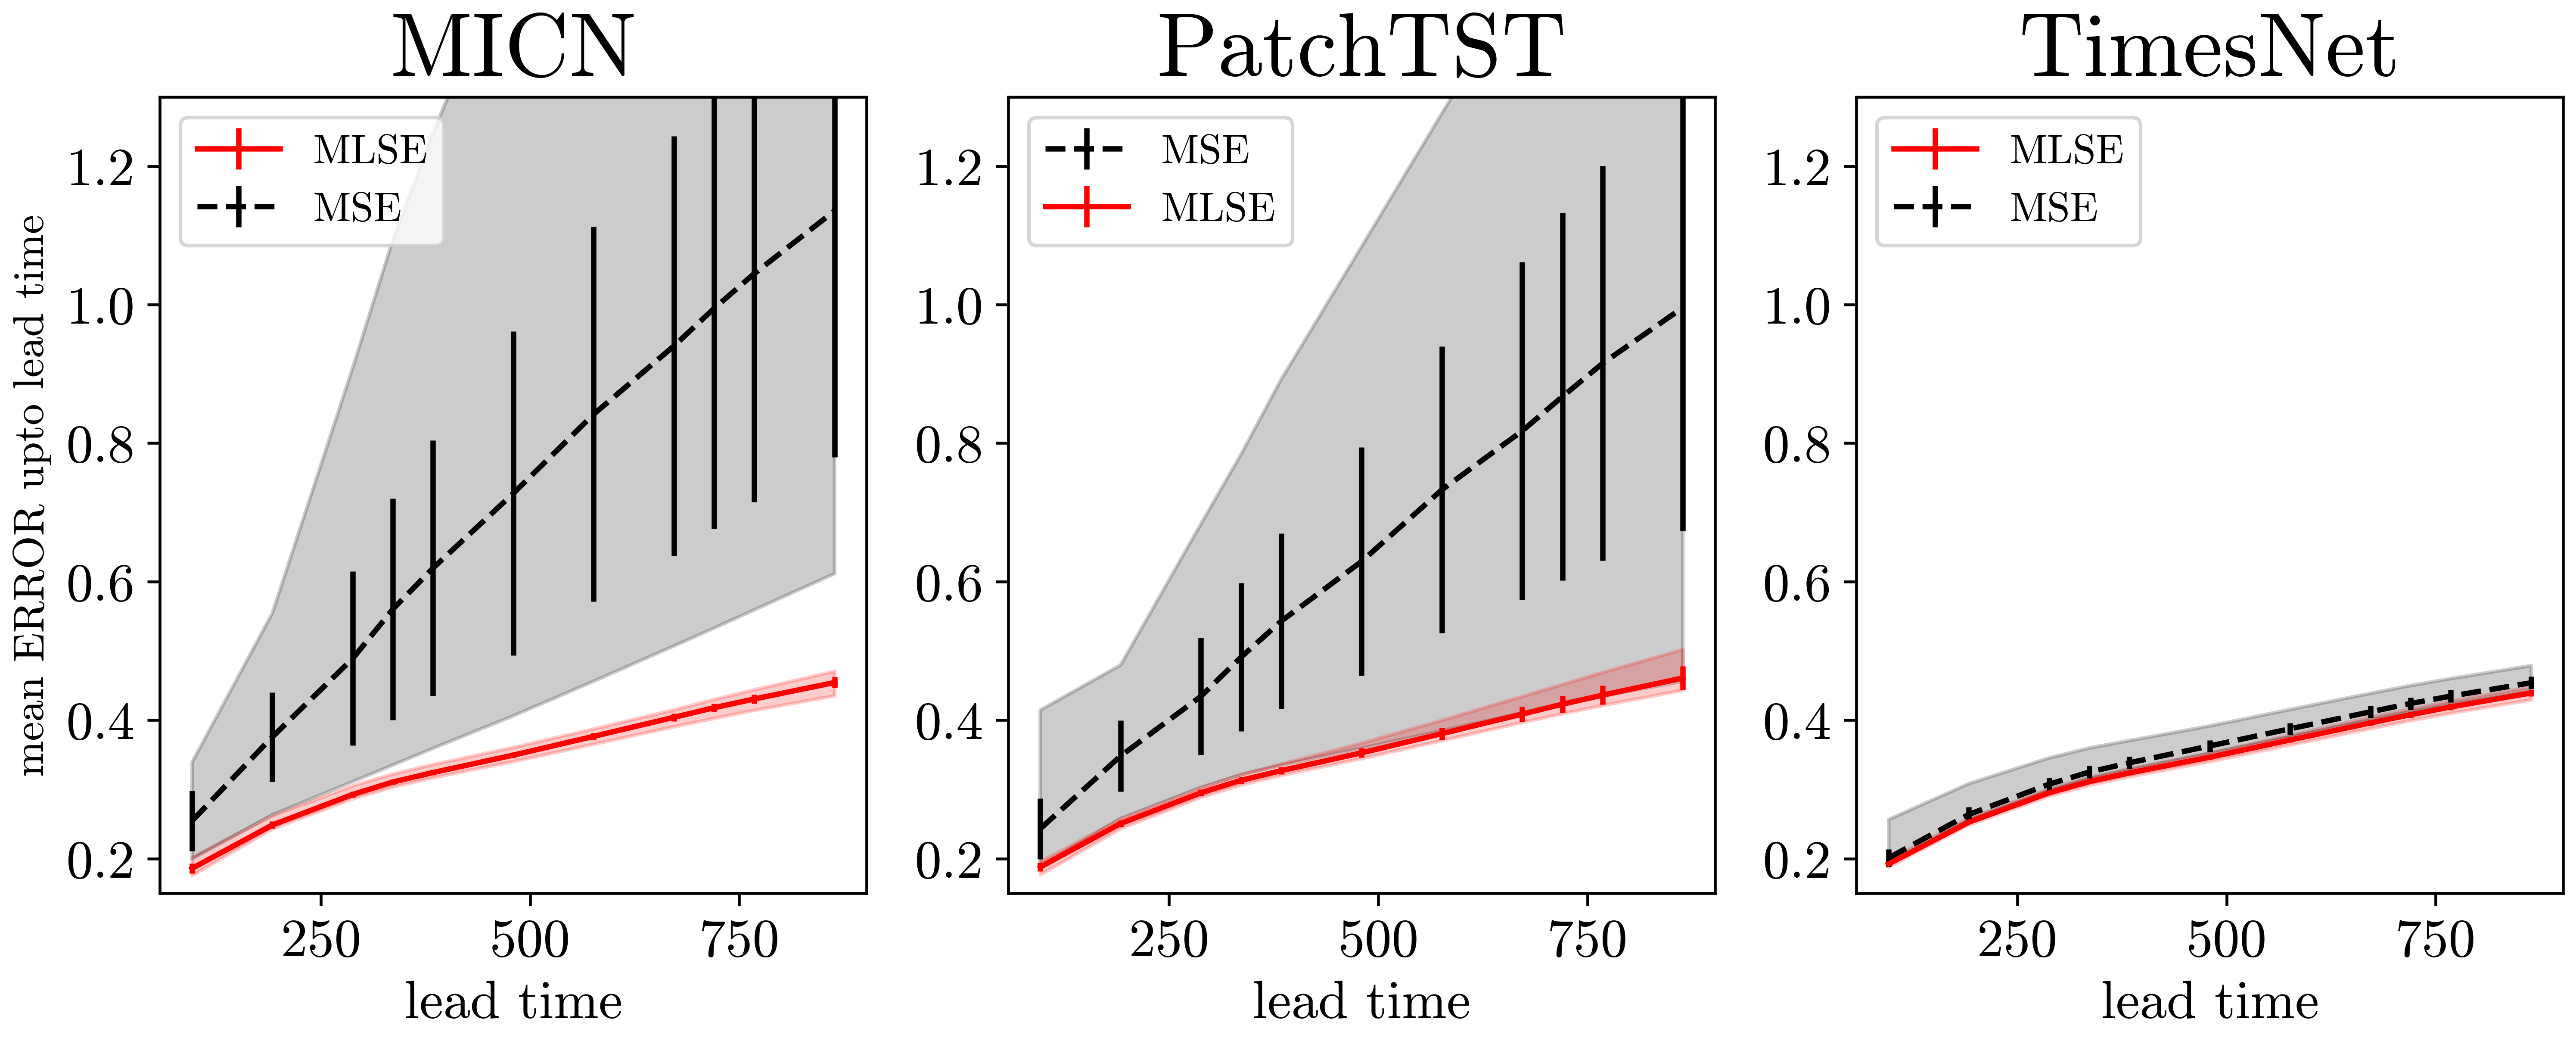

In [38]:
%matplotlib inline
with plt.style.context('ieee','no-latex'):
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    i = 0
    for ax, model in zip(axes, pool['TSL-ETTm2'].keys()):
        model_pool = pool['TSL-ETTm2'][model]
        for graph, graph_pool in model_pool.items():
            data_x = []
            data_y = []
            data_b = []
            data_y_min = []
            data_y_max = []
            for error_type, error_list in graph_pool.items():
                data_x.append(int(error_type.replace('test_error_','')))
                data_y.append(np.mean(error_list))
                data_b.append(np.std(error_list))
                data_y_min.append(np.min(error_list))
                data_y_max.append(np.max(error_list))
            data_x = np.array(data_x)
            data_y = np.array(data_y)
            data_b = np.array(data_b)
            data_y_min = np.array(data_y_min)
            data_y_max = np.array(data_y_max)
            sorted_order = np.argsort(data_x)
            data_x = data_x[sorted_order]
            data_y = data_y[sorted_order]
            data_b = data_b[sorted_order]
            data_y_min = data_y_min[sorted_order]
            data_y_max = data_y_max[sorted_order]
            ax.fill_between(data_x, data_y_min, data_y_max, color=color_map[graph], alpha=0.2)
            ax.errorbar(x=data_x, y=data_y, yerr=data_b,label=label_map[graph], c=color_map[graph],linestyle=line_map[graph])
        ax.set_title(model, fontsize=25)
        ax.set_xlabel('lead time', fontsize=15)
        if i==0:ax.set_ylabel('mean ERROR upto lead time', fontsize=12)
        ax.set_ylim([0.15,1.3])
        ax.legend(loc='upper left',fontsize='x-large')
        ax.tick_params(axis='both', which='major', labelsize=15)
        i+=1
        
fig.savefig('figures/Varing_in_ETTM2.png')

In [73]:
## mean
import pandas as pd
global count_red 
global count_blue
global count_right
count_red  = 0
count_blue = 0
count_right= 0 



df = pd.DataFrame(rawdata, columns=['model', 'graph', 'metric', 'mean_error','std_error'])

df_pivot = df.pivot_table(index=['metric'], columns=['model', 'graph'], values='mean_error')


styled_df = df_pivot.style.format("{:.3f}").set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th.level0', 'props': [('border-bottom', '3px solid black')]},
    {'selector': 'th.level1', 'props': [('border-bottom', '2px solid black')]},
    {'selector': 'th.col_heading', 'props': [('border-right', '2px solid black')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '4px 2px')]},
    
    {'selector': 'td.col_heading.level0', 'props': [('border-left', '2px solid black')]},
    {'selector': 'td.row_heading.level1', 'props': [('border-left', '2px solid black')]},
])

styled_df
